In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def order_points(points):
    rect = np.zeros((4, 2), dtype="float32")
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]
    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]
    return rect

In [3]:
def four_point_transform(image, points):
    rect = order_points(points)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [7]:
def get_top_down_view(image):
    image_calibration = cv2.imread('./pictures/2.jpg')
    print(type(image_calibration))
    gray = cv2.cvtColor(image_calibration, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    chessboard_contour = None

    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            chessboard_contour = approx
            break

    if chessboard_contour is not None:
        warped = four_point_transform(image, chessboard_contour.reshape(4, 2))
        #cv2.imshow("Warped", warped)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        return warped
    else:
        print("Chessboard not found.")

<class 'numpy.ndarray'>


(-0.5, 838.5, 575.5, -0.5)

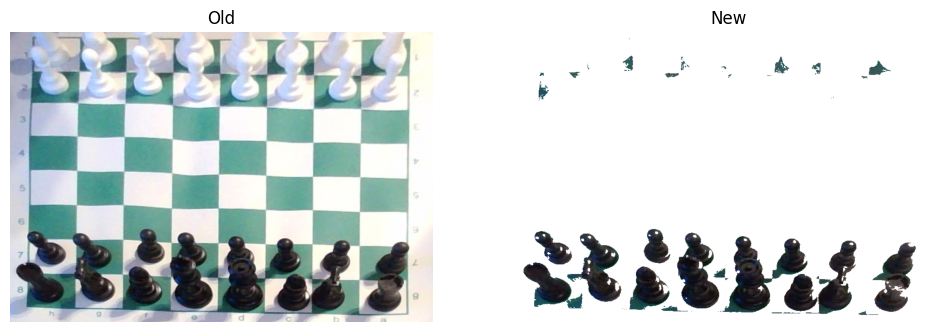

In [23]:
img = cv2.imread("./pictures/3.jpg")

topdown = get_top_down_view(img)
img_lane_hsv = cv2.cvtColor(topdown, cv2.COLOR_RGB2HSV)



img_green = cv2.inRange(img_lane_hsv, (0, 0, 0), (255, 255, 100))
img_filtered_lane = topdown.copy()
img_filtered_lane[np.where(img_green==0)] = 255


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(topdown, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Old")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img_filtered_lane, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"New")
axes[1].axis("off")